<a href="https://colab.research.google.com/github/JadeKim/Quanvolution-lab/blob/main/jade_cnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn # basic neural network
import torch.nn.functional as F # Convolutional functions
import torch.optim as optim # optimizers
from torchvision import datasets, transforms # image datasets, image transformations

In [ ]:
torch.cuda.is_available()

False

In [ ]:
trn_dataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.1307,), (0.3081,)) # mean, std of MNIST.
                             ])) 

val_dataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

In [ ]:
print(type(trn_dataset))
print(len(trn_dataset))
print(len(val_dataset))
print(len(trn_dataset[0][0][0][0]))


<class 'torchvision.datasets.mnist.MNIST'>
60000
10000
28


In [ ]:
# Batch iterator
batch_size = 6
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [ ]:
input = torch.Tensor(1, 1, 28, 28)
conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5) # 50@24*24
# activation ReLU
pool1 = nn.MaxPool2d(2) # 50@12*12
conv2 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=5) # 64@8*8
# activation ReLU
pool2 = nn.MaxPool2d(2) # 64@4*4
output = pool2(conv2(pool1(conv1(input))))
fc1 = output.view(output.size(0), -1)
do = nn.Dropout(p=0.4)
fc2 = nn.Linear(1024, 10)
print(conv1(input).shape)
print(pool1(conv1(input)).shape)
print(conv2(pool1(conv1(input))).shape)
print(output.shape)
print(fc1.shape)
print(do(fc1).shape)
print(fc2(do(fc1)).shape)

# Result:
# torch.Size([1, 50, 24, 24])
# torch.Size([1, 50, 12, 12])
# torch.Size([1, 64, 8, 8])
# torch.Size([1, 64, 4, 4])
# torch.Size([1, 1024])
# torch.Size([1, 1024])
# torch.Size([1, 10])

torch.Size([1, 50, 24, 24])
torch.Size([1, 50, 12, 12])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 4, 4])
torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 10])


In [ ]:
# construct model on cuda if available
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self, model='cnn'):
        super(CNNClassifier, self).__init__()
        
        if model == 'random':
            self.conv_module = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5), # 50@24*24
                nn.Sigmoid(),
                nn.MaxPool2d(2), # 50@12*12
                nn.Conv2d(in_channels=50, out_channels=64, kernel_size=5), # 64@8*8
                nn.ReLU(),
                nn.MaxPool2d(2) # 64@4*4
            )
        else:
            self.conv_module = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5), # 50@24*24
                nn.ReLU(),
                nn.MaxPool2d(2), # 50@12*12
                nn.Conv2d(in_channels=50, out_channels=64, kernel_size=5), # 64@8*8
                nn.ReLU(),
                nn.MaxPool2d(2) # 64@4*4
            )

        self.fc_module = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )
        
        # cuda
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) 
        # 64@4*4
        out = out.view(out.size(0), -1) # 1*1024
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [ ]:
cnn = CNNClassifier()
random = CNNClassifier('random')
print(cnn)
print(random)

CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): ReLU()
    (2): Linear(in_features=1024, o

In [ ]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
optimizer_r = optim.Adam(random.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 1
num_batches = len(trn_loader)

trn_loss_list = []
val_loss_list = []
acc_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    correct = 0.0
    for i, data in enumerate(trn_loader):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        _, predicted = torch.max(model_output.data, 1)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        correct += (predicted == label).float().sum()/batch_size

        # del (memory issue)
        del loss
        del model_output
        
        if (i+1) % 100 == 0:
            with torch.no_grad():
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    val_output = cnn(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | trn acc: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader), correct / (i+1)
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            acc_list.append(correct / (i+1))
            trn_loss = 0.0
print()
trn_loss_list_r = []
val_loss_list_r = []
acc_list_r = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    correct = 0.0
    for i, data in enumerate(trn_loader):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer_r.zero_grad()
        # forward propagation
        model_output = random(x)
        _, predicted = torch.max(model_output.data, 1)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer_r.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        correct += (predicted == label).float().sum()/batch_size

        # del (memory issue)
        del loss
        del model_output
        
        if (i+1) % 100 == 0:
            with torch.no_grad():
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    val_output = random(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | trn acc: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader), correct / (i+1)
            ))            
            
            trn_loss_list_r.append(trn_loss/100)
            val_loss_list_r.append(val_loss/len(val_loader))
            acc_list_r.append(correct / (i+1))
            trn_loss = 0.0

epoch: 1/1 | step: 100/10000 | trn loss: 2.0933 | val loss: 1.8657 | trn acc: 0.3733
epoch: 1/1 | step: 200/10000 | trn loss: 1.7949 | val loss: 1.7931 | trn acc: 0.5200
epoch: 1/1 | step: 300/10000 | trn loss: 1.7229 | val loss: 1.6664 | trn acc: 0.5939
epoch: 1/1 | step: 400/10000 | trn loss: 1.6731 | val loss: 1.6347 | trn acc: 0.6429
epoch: 1/1 | step: 500/10000 | trn loss: 1.6441 | val loss: 1.6305 | trn acc: 0.6773
epoch: 1/1 | step: 600/10000 | trn loss: 1.6148 | val loss: 1.6225 | trn acc: 0.7067
epoch: 1/1 | step: 700/10000 | trn loss: 1.6380 | val loss: 1.6197 | trn acc: 0.7236
epoch: 1/1 | step: 800/10000 | trn loss: 1.6050 | val loss: 1.6324 | trn acc: 0.7400
epoch: 1/1 | step: 900/10000 | trn loss: 1.6257 | val loss: 1.5765 | trn acc: 0.7504
epoch: 1/1 | step: 1000/10000 | trn loss: 1.5472 | val loss: 1.5420 | trn acc: 0.7668
epoch: 1/1 | step: 1100/10000 | trn loss: 1.5628 | val loss: 1.5265 | trn acc: 0.7792
epoch: 1/1 | step: 1200/10000 | trn loss: 1.5431 | val loss: 1.

Text(0, 0.5, 'Test set accuracy (%)')

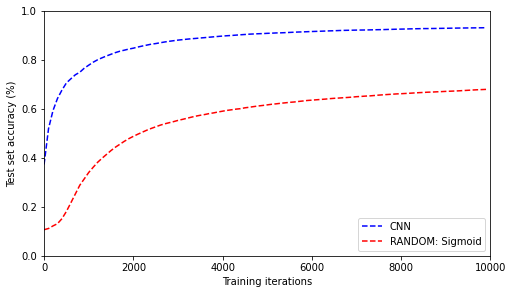

In [ ]:
plt.figure(figsize=(8,4.5))
plt.plot(acc_list, label="CNN", color='blue', linestyle='--')
plt.plot(acc_list_r, label="RANDOM: Sigmoid", color='red', linestyle='--')
plt.legend()
plt.xlim(0, 100)
plt.xticks([0, 20, 40, 60, 80, 100],[0, 2000, 4000, 6000, 8000, 10000])
plt.ylim(0, 1)
plt.xlabel("Training iterations")
plt.ylabel("Test set accuracy (%)")